# STAT2005 Computer Simulation 

## Lecture 3 - Continuous Random Variables 

**Felix Chan, School of Economics and Finance**

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.special as spsp
import matplotlib.pyplot as plt
from matplotlib import animation 

In [35]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9,6]
plt.rcParams['animation.html'] = 'html5'

### Story so far

- We discussed pseudo random number generators: LCG and MCG. 
- We discussed how to simulate random permutations. 
- We discussed how to simulate a discrete random variables based on its PMF. 
- This week we focus on continuous random variables. 

## Inversion Method

- Recall the method we used to simulate discrete random variables is based on the inversion method. 
- The basic idea is to note that if $F(x)$ is the CDF of a discrete random variable $X$ that takes on values $\{1,2,3...\}$, and if $u$ is a random draw from $U(0,1)$ then $Pr \left [ F(x-1) < u < F(x) \right ] = F(x)-F(x-1) = \Pr (X=x)$. 
- The same idea can apply to continuous random variables. 

- Consider a continuous random variable, $X$ which takes on values from $\mathbb{R}$. Let $F(x)$ be its cumulative distribution function 
- Note that the range of $F(x)$ is $[0,1]$, so if the inverse of $F(x)$ exists then $x = F^{-1} (p_x)$ with $p_x\in [0,1]$, the cumulative probability of $X$ at $x$. 
- Let $u$ be a random draw from $U(0,1)$, we can then simulate $X$ by setting $x= F^{-1}(u)$. 

    ![inversion](./pics/lecture03_inversion.png)

The proof for this is exactly the same as in the discrete case. 
$$\begin{align} \Pr \left [ u \in (F(a), F(b)) \right ] =& F(b) - F(a) \\ =&\Pr (a\leq X \leq b) \end{align}$$

### Exponential distribution 

Recall the PDF of an exponential distribution is 

$$ f(x;\lambda) = \lambda \exp \left ( -\lambda x \right ). $$
The corresponding CDF is 
$$\begin{align} F(x; \lambda ) =& \int^x_0 \lambda \exp \left ( - \lambda s \right ) ds \\ 
    =& 1-\exp \left (-\lambda x \right ) \end{align}.$$
This means the inverse of the CDF is 
$$ F^{-1} (u) = -\frac{\log (1-u)}{\lambda}. $$
This means we can simulate an exponentially distributed random variable by taking a random draw from $U(0,1)$ and set 
$$x = -\frac{\log (1-u)}{\lambda}.$$

In [10]:
def RV_exponential(N,l):
    """
    Function to generate N random draws from an exponential distribution based on the parameter l. 
    Inputs:
        N: positive int. The number of random draws. 
        l: positive scalar. The parameter in the exponential function. 
    Output:
        x: (N,) numpy array. N random draws of Exp(l). 
    
    """
    
    if l <= 0:
        print('The parameter must be positive.')
    elif (type(N) != int)|(N < 0):
        print('The number of draws must be a positive interger.')
    else:
        u = sps.uniform.rvs(size=N)
        x = - np.log(1-u)/l
    return x

In [63]:
N,l = 1000,1
x = RV_exponential(N,l)

In [64]:
plt.rcParams['figure.figsize'] = [9,6]

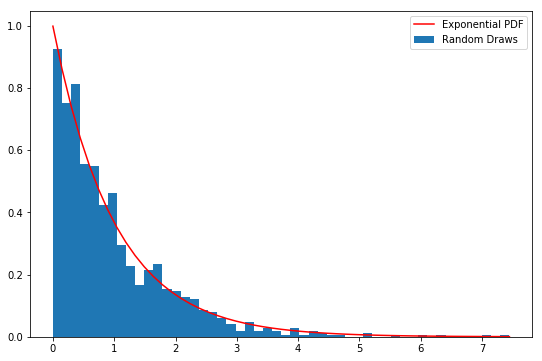

In [65]:
xset = plt.hist(x, bins=50, normed=1)
plt.plot(xset[1], l*np.exp(-l*xset[1]), color='red')
plt.legend(['Exponential PDF', 'Random Draws'])

### Limitation

- One problem with the inversion method for continuous random variables is that we need to know the inverse of the CDF. 
- Or at least we need to know how to compute the inverse of the CDF numerically. 
- An example is the normal distribution. 
- The CDF of normal distribution does not have an analytical form but we can compute the CDF and its inverse for any given points (numerically). 


### Simulating normal random variable by inversion method 

- Recall the pdf of a normal distribution with a given mean $\mu$ and standard deviation $\sigma$ is 
$$ \phi(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left [ - \frac{\left (x-\mu\right )^2}{2\sigma^2} \right ]$$
and the CDF is 
$$ \Phi ( x; \mu, \sigma ) = \int_{-\infty}^x \phi(s; \mu, \sigma) ds. $$

- We can therefore generate $N$ random draws from a normal distribution by 
    1. Generate $N$ random draws from $U(0,1)$, i.e. $(u_1,\ldots, u_n)$. 
    2. Set $x_i = \Phi^{-1} (u_i; \mu, \sigma)$. 
    3. The vector $(x_1,\ldots,x_N)$ gives the desired random draws from the normal distribution. 

In [27]:
def RV_normal_inv(N,m,s):
    """
    Generate N random draws of N(m,s) by the inversion method. 
    Inputs:
        N: positive int. The number of random draws. 
        m: float. The mean of the normal random variable. 
        s: positive float. The standard deviation of the normal random variable. 
    Output:
        x: (N,) numpy array. The N random draws of N(m,s) by the inversion method. 
    """
    
    if (N<0)|(type(N)!=int):
        print('The number of draws must be positive integer.')
    elif s<=0:
        print('The standard deivation must be positive.')
    else:
        u = sps.uniform.rvs(size=N)
        x = sps.norm.isf(1-u,loc=m,scale=s)
    return x

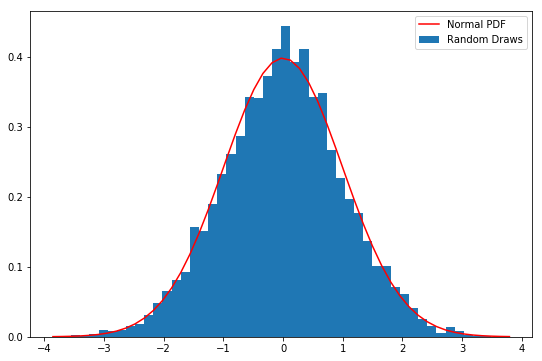

In [66]:
N,m,s = 5000,0,1
x = RV_normal_inv(N,m,s)
xset = plt.hist(x,bins=50,normed=1)
plt.plot(xset[1],sps.norm.pdf(xset[1],loc=m,scale=s),color='red')
plt.legend(['Normal PDF', 'Random Draws'])

### Accept-Reject

- Sometimes the inverse of the CDF is difficult to compute. 
- Ideally we want a method that relies on ONLY the PDF (not even CDF). 
- Computationally PDF is often (if not always) easier to compute than CDF. 
- This is one of the advantages of the accept-reject method. 
- Basic idea (the layman version): 
    1. Imagine you plot the PDF on a piece of paper and draw a box around it. 
    2. Hang up that picture then pick up your paint-ball gun. 
    3. Randomly shooting at the picture $N$ times. 
    4. List the coordinates of all the shots that are under the PDF. 
    5. Use the $x$-coordinates of those shots as the random draws. 

In [68]:
k=1.2
f = lambda x: 0.6-0.3*np.power(x,2)
xset = np.arange(-1,1,0.01)
g = k*0.5*np.ones(len(xset))
fset = np.array([f(x) for x in xset])

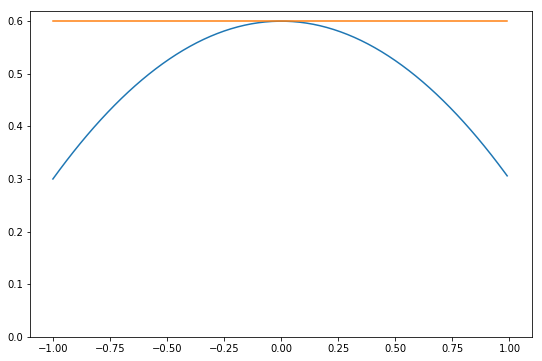

In [69]:
N = 100
n = 0
aset = []
accept =[]
reject = []
color_index = []
while n<N:
    x = sps.uniform.rvs(-1,2)
    candidate = sps.uniform.rvs(0,k*0.5)
    aset.append([x,candidate])
    if f(x) > candidate:
        accept.append([x,candidate])
        color_index.append(1)
        n = n + 1
    else:
        reject.append([x,candidate])
        color_index.append(0)
aset = np.array(aset)
accept = np.array(accept)
reject = np.array(reject)
fig, ax = plt.subplots()
ax.set_xlim(-1.1,1.1)
ax.set_ylim(0,0.62)
ax.plot(xset, fset)
ax.plot(xset, g)

def accept_reject(i):
    if color_index[i] == 0:
        ax.scatter(aset.transpose()[0][i], aset.transpose()[1][i], c='r')
    else:
        ax.scatter(aset.transpose()[0][i], aset.transpose()[1][i], c='b')

In [70]:
ani = animation.FuncAnimation(fig,accept_reject,frames=np.arange(len(aset)))
ani

Here is what happened mathematically. Consider the following PDF:
$$ f(x) = 0.6-0.3x^2$$
over the interval $x\in [-1,1]$. 

First to make sure this is a proper PDF:
1. $f(x)>0$ for all $x\in [-1,1]$. 
2. The area under the curve must be 1. 
$$ F(x) = \int^1_{-1} f(x) dx = 1.$$

1. We define the "box". In this case, the entire PDF can be bounded by $[-1,1]\times 0.6$. 

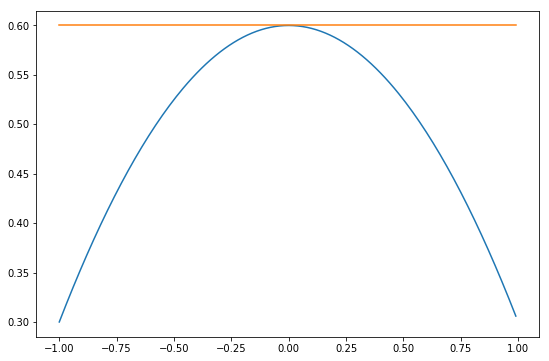

In [71]:
plt.plot(xset, fset)
plt.plot(xset, g)

- We then "shoot" at this "picture" with our paint-ball gun. 
- This simply means we are generating a sequence of random points within the "box" we defined earlier. 
- How do we do that?

- a sequence of points is just a sequence of coordinates, $(x_i, y_i)$. 
- Note that the $x$-coordinate lies between $[-1,1]$ so we can generate the $x$-coordinate as $U[-1,1]$. 
- The $y$-coordinate lies between $[0,0.6]$, so we can generate the $y$-coordinate as $U[0,0.6]$. 
- For every draw of the $(x,y)$ coordinate from the two uniform distributions give us a candidate. 
- The decision rule is that if $y>f(x)$, that is, if the point is above the density, then we reject the candidate. If the $y<f(x)$, that is, if the point is below the density, then we accept. 

In [72]:
tempx_r, tempy_r = [], []
for a in reject:
    tempx_r.append(a[0])
    tempy_r.append(a[1])
tempx_a = []
tempy_a = []
for a in accept:
    tempx_a.append(a[0])
    tempy_a.append(a[1])

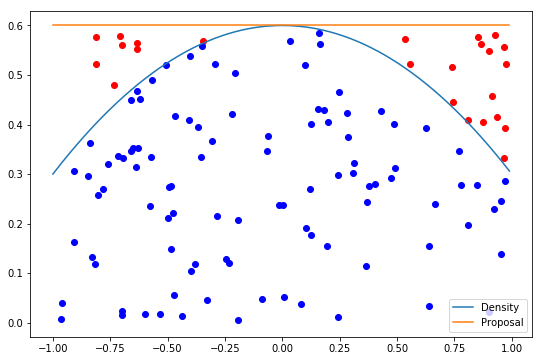

In [73]:
plt.plot(xset, fset)
plt.plot(xset, g)
plt.legend(['Density', 'Proposal'])
plt.scatter(tempx_r,tempy_r,c='r')
plt.scatter(tempx_a,tempy_a,c='b')

### Generalizing the idea

- Not all the density can be "contained" within a "box". 
- Turns out we don't need a "box" as such. This will work as long as there is another function that is bounded above the PDF for all $x$. 
- The only stipulation is that this function has to be proportional to a distribution which we do know how to simulate, i.e. $h(x) = cg(x)$ for some $c\geq 1$ and $g(x)$ is a PDF of a random variable that we do know how to simulate. 
- The reason is that for each point we need two coordinates $(x_i,y_i)$ where both must come from a random draw. 
- $x_i$ is coming from a known (proposal) distribution, which has the PDF, $g(x)$, and we know how to simulate it. 
- Conditional on $x_i$, we need to be able to draw the $y$ coordinator (height). The draw must include the possibility that the point is above or below the desired density. 
- This means $y_i \in [0, cg(x_i)]$ and if $y_i < f(x_i)$ then we return $x_i$ as the next draw, otherwise, we discard the draw and repeat the process. 

### Proof (Accept-reject algorithm)

To proof this algorithm actually works, we need to show that 
$$ \Pr \left [ X< x | U < f(x) \right ] = F(x)$$ 
where $U$ is an uniform random variable with distribution, $U[0, cg(x)]$, which can be expressed as $U = u c g(x)$ where $u$ is an $U(0,1)$ random variable. 


By Bayes Theorem, we know that

$$ \Pr \left [ X< x | U < f(x) \right ] = \Pr \left [ U < f(x) | X< x \right ] \frac{ \Pr ( X< x)}{ \Pr( U< f(x) )} $$

Note that $\Pr ( X<x ) = G(x)$ where $G(x)$ is the cumulative distribution of the proposal distribution (the draw of the $x$ coordinate) and 
$$\begin{align} \Pr ( U < f(x) ) =& \mathbb{E} \left \{ \Pr [ u c g(x) < f(x) ] \bigg | x \right \}\\
                        =& \mathbb{E} \left \{  \Pr \left [ u < \frac{ f(x)}{cg(x)} \right ] \bigg | x \right \} \\
                        =& \int \frac{ f(x)}{cg(x)} g(x) dx \\
                        =& \frac{1}{c} \int f(x) dx \\
                        =& \frac{1}{c}. 
                        \end{align}$$

Now, 
$$ \begin{align} \Pr \left [ U < f(x) | X< x \right ] =& \frac{\Pr \left [ U < f(x) , X< x \right ]}{\Pr (X<x)} \\
                                        =&  \frac{\Pr \left [ U < f(x) , X< x \right ]}{G(x)} \\
                                        =& \frac{1}{G(x)} \int^x_{-\infty} \Pr \left [ u < \frac{f(s)}{cg(s)}\bigg | X=s<x \right ] g(s) ds \\
                                        =& \frac{1}{G(x)} \int^x_{-\infty} \frac{f(s)}{cg(s)} g(s) ds \\
                                        =& \frac{F(x)}{cG(x)}. 
                                        \end{align} $$
                                        
    

Putting these together:

$$ \begin{align} \Pr \left [ X< x | U < f(x) \right ] =& \Pr \left [ U < f(x) | X< x \right ] \frac{ \Pr ( X< x)}{ \Pr( U< f(x) )} \\
        =& \frac{F(x)}{cG(x)} \frac{G(x)}{1/c} \\
        =& \frac{F(x)}{cG(x)} cG(x) \\
        =& F(x). 
        \end{align} $$



Note that $\Pr [ U < f(x) ] = 1/c$ tells us that the probability of acceptance is $1/c$ on average. So if $c$ is large, then the accept-reject algorithm will end up with a large rejected sample. So for this method to be efficient, we need $c$ to be as close to 1 as possible. 

### Simulating $N(0,1)$ using Accept-reject algorithm

Let $Y\sim N(\mu, \sigma^2)$ and since $Y$ can be expressed as $Y = \sigma X + \mu$ where $X\sim N(0,1)$, this means as long as we can simulate $N(0,1)$, we can simulate normal distribution with different mean and variance.

Since $N(0,1)$ is symmetrical around $0$, this means we can express $X$ as $X=S|X|$ where $S$ denotes the sign. 

Note that the symmetry feature allows us to simulate $S$ as a random variable that takes on $\{-1,1\}$ each with $0.5$ probability. We know how to do that. 

We therefore need to simulate $|X|$ which is also known as the *half normal* distribution. Since the PDF of a standard normal is 

$$\phi(x) = \frac{1}{\sqrt{2\pi}} \exp \left ( -\frac{x^2}{2} \right )$$

with $\int \exp (-x^2/2) = \sqrt{2\pi}$, the PDF of the half normal is therefore 

$$ |\phi| (x) = \frac{2}{\sqrt{2\pi}} \exp \left ( -\frac{x^2}{2} \right ). $$

To simulate the half normal, we first note that the exponential distribution $g(x) = \exp (-x)$ can be used as the proposal. That is, we need to identify $c$ such that 

$$c\exp(-x) \geq  \frac{2}{\sqrt{2\pi}} \exp \left ( -\frac{x^2}{2} \right )$$ 

for all $x > 0$.

After some simple algebra: 
$$ \begin{align} 
        c \geq& \frac{2}{\sqrt{2\pi}} \exp \left ( x - \frac{x^2}{2} \right ) \\
        \log c \geq & \log \frac{2}{\sqrt{2\pi}} + x - \frac{x^2}{2}. 
        \end{align}
$$
Note that the quadratic function on the right hand side has a maximum at $x=1$. Thus 
$$ \begin{align} 
            \log c \geq& \log \frac{2}{\sqrt{2\pi}} + \frac{1}{2} \\
            c \geq& \sqrt{ \frac{2e}{\pi} } \\
            \approx & 1.316
            \end{align} 
$$


In [9]:
def HN(x):
    """
    PDF of a standard half normal. 
    Inputs:
        x: positive float. 
    Output
        y: The PDF of a half normal at x. 
    """
    return 2*np.exp(-np.power(x,2)/2)/np.power(2*np.pi, 0.5)

def exp_envelop(x,c,l): 
    """
    Define an exponential distribution as an envelop for Accept-reject. 
    Inputs:
        x: positive float. 
        c: float, c>1. The scalaring factor. 
        l: positive float. The parameter of the exponential distribution. 
    """
    
    return c*l*np.exp(-l*x)

c = 1.316
xset = np.arange(0,10,0.01)
fset = HN(xset)
gset = exp_envelop(xset,c,1)

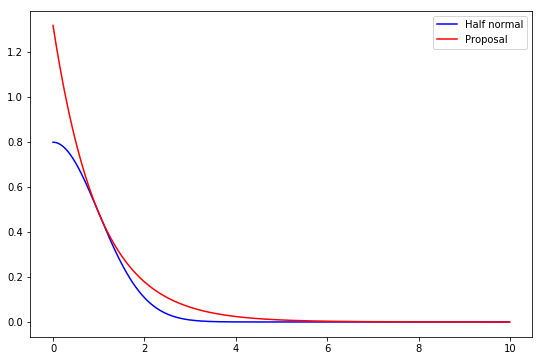

In [36]:
plt.plot(xset, fset, 'b', xset, gset, 'r')
plt.legend(['Half normal', 'Proposal'])

In [24]:
def Accept_reject(N,f,g,g_draw): 
    """
    General accept-reject algorithm based on the target distribution f and the proposal g. 
    Inputs:
        N: Number of draws required. 
        f: function. The target distribution.
        g: function. The proposal. 
        g_draw: function. Random number generator based on the proposal. 
    Output:
        x: (N,) numpy array. 
    """
    
    x = np.zeros(N)
    filled = 0 
    while filled < N: 
        candidate = g_draw(1)[0]
        u = sps.uniform.rvs(size=1)
        if u*g(candidate) < f(candidate):
            x[filled] = candidate
            filled = filled + 1
    return x


In [ ]:
def gen_sign(N):
    """
    Simulating a random variable which takes on values {-1,1} with equal probability. 
    Input:
        N: positive int. The number of random draw. 
    Output:
        s: (N,) numpy array, condtaining -1 or 1. 
    
    """
    if (N<0)|(type(N) != int ):
        print('The number of draw must be a positive integer.')
    else:
        s = np.ones(N)
        U = sps.uniform.rvs(size=N)
        s[U<0.5] = -1
    return s
    

In [27]:
N=5000
g = lambda x: exp_envelop(x,1.32,1)
g_draw = lambda N: sps.expon.rvs(size=N)
RV_normal = gen_sign(N)*Accept_reject(N,HN,g,g_draw)

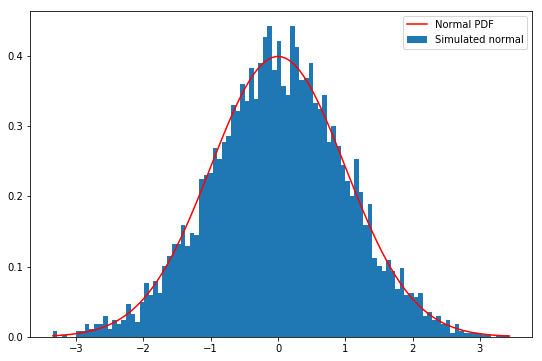

In [37]:
hist = plt.hist(RV_normal,bins=100,normed=1)
plt.plot(hist[1], sps.norm.pdf(hist[1]), color='red')
plt.legend(['Normal PDF','Simulated normal'])